In [68]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import itertools

import numpy as np
import bottleneck as bn
import pandas as pd
from sklearn import decomposition
import networkx as nx
# import networkx.algorithms.approximation as nxa
import igraph as ig
# # http://stackoverflow.com/questions/35279733/what-could-cause-networkx-pygraphviz-to-work-fine-alone-but-not-together
# from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import missingno as msno
import palettable
%matplotlib inline

np.set_printoptions(linewidth=145, precision=4)

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from collections import defaultdict, Counter
from IPython.display import display as disp
from IPython.display import display_markdown
mdisp = lambda s: display_markdown(s, raw=True)

from speclib import loaders
from speclib import plotting
from speclib import graph
from speclib import misc
from speclib import userActivityFunctions

for k, v in {'font.size': 13.0,
             'legend.fontsize': 13.0,
             'axes.labelsize': 12.0,
             'axes.titlesize': 15.0,
             'figure.figsize': [16.0, 7.0],
             'figure.dpi': 200,
             'figure.titlesize': 'large',
             'xtick.labelsize': 13.0,
             'ytick.labelsize': 13.0}.items():
    mpl.rcParams[k] = v

%load_ext watermark
%watermark -a "Allan Leander Rostock Hansen" -u -d -v -p numpy,bottleneck,pandas,matplotlib,sklearn,missingno
%watermark  -p networkx,igraph,seaborn,palettable

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Allan Leander Rostock Hansen 
last updated: 2017-09-12 

CPython 3.6.1
IPython 5.4.1

numpy 1.12.1
bottleneck 1.2.0
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18.1
missingno 0.3.5
networkx 2.0.dev_20170815195234
igraph 0.7.1
seaborn 0.7.1
palettable 3.0.0


Two similar graphs, but different node labels

In [17]:
g0 = nx.DiGraph() 
g0.add_nodes_from([0, 1, 2, 3])
g0.add_edges_from([(0, 1), (1, 0), (0, 2), (1, 2)]) 
a0 = np.array(nx.adjacency_matrix(g0).todense())

In [18]:
g1 = nx.DiGraph() 
g1.add_nodes_from([0, 1, 2, 3])
g1.add_edges_from([(1, 2), (2, 1), (1, 3), (2, 3)]) 
a1 = np.array(nx.adjacency_matrix(g1).todense())

In [19]:
a0

array([[0, 1, 1, 0],
       [1, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int64)

In [20]:
a1

array([[0, 0, 0, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 1],
       [0, 0, 0, 0]], dtype=int64)

In [21]:
perms = [ (np.dot(misc.stackColumns(a0p), misc.stackColumns(a1)), p, a0p)
    for (p, a0p) in graph.genAllMatrixPermutations(a0) ]
a0p = max(perms, key=lambda x: x[0])
print(*a0p, sep='\n')

4
(3, 0, 1, 2)
[[0 0 0 0]
 [0 0 1 1]
 [0 1 0 1]
 [0 0 0 0]]


A dot-product value of 4 which is similar to the sum of the matrix elements is a complete match

Now, lets try weighted matrices

In [24]:
g2 = nx.DiGraph()
g2.add_nodes_from([0, 1, 2, 3])
g2.add_weighted_edges_from([(0, 1, 0.5), (1, 0, 0.5), (0, 2, 0.25), (1, 2, 0.25)])
a2 = np.array(nx.adjacency_matrix(g2).todense())

g3 = nx.DiGraph()
g3.add_nodes_from([0, 1, 2, 3])
g3.add_weighted_edges_from([(1, 2, 0.5), (2, 1, 0.5), (1, 3, 0.25), (2, 3, 0.25)])
a3 = np.array(nx.adjacency_matrix(g3).todense())


In [25]:
a2

array([[ 0.  ,  0.5 ,  0.25,  0.  ],
       [ 0.5 ,  0.  ,  0.25,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

In [26]:
a3

array([[ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.5 ,  0.25],
       [ 0.  ,  0.5 ,  0.  ,  0.25],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

In [29]:
perms = [(np.dot(misc.stackColumns(a2p), misc.stackColumns(a3)), p, a2p)
         for (p, a2p) in graph.genAllMatrixPermutations(a2)]
a2p = max(perms, key=lambda x: x[0])
print(*a2p, sep='\n') 

0.625
(3, 0, 1, 2)
[[ 0.    0.    0.    0.  ]
 [ 0.    0.    0.5   0.25]
 [ 0.    0.5   0.    0.25]
 [ 0.    0.    0.    0.  ]]


The product of the induvidually sorted matrices yields the largest possible dot product, and this is a good value to compare the permuted value to.

In [30]:
np.dot(np.sort(a2.flat), np.sort(a3.flat))

0.625

* Now do the same as above, but for differently weighted graphs.
* And also do it for graphs which are almost the same connections.
* And do it for large graphs in which there two dominant communities, with just a bit of crosstalk.
* And investigate how directionality affects this measure – maybe use a sum instead of a product?
* Investigate how network size vs. sparsity affects this measure.
* Can softmax be applied here?

Same total weights, but differently weighted.
Besides the weights (and labels) the number of connections is still the same.

In [39]:
g4 = nx.DiGraph()
g4.add_nodes_from([0, 1, 2, 3])
g4.add_weighted_edges_from([(0, 1, 0.5), (1, 0, 0.5), (0, 2, 0.5), (1, 2, 0.25)])
a4 = np.array(nx.adjacency_matrix(g4).todense())
g5 = nx.DiGraph()
g5.add_nodes_from([0, 1, 2, 3])
g5.add_weighted_edges_from([(1, 2, 0.5), (2, 1, 0.5), (1, 3, 0.25), (2, 3, 0.5)])
a5 = np.array(nx.adjacency_matrix(g5).todense())


In [35]:
a4

array([[ 0.  ,  0.5 ,  0.5 ,  0.  ],
       [ 0.5 ,  0.  ,  0.25,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

In [36]:
a5

array([[ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.5 ,  0.25],
       [ 0.  ,  0.5 ,  0.  ,  0.5 ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

In [37]:
perms = [(np.dot(misc.stackColumns(a4p), misc.stackColumns(a5)), p, a4p)
         for (p, a4p) in graph.genAllMatrixPermutations(a4)]
a4p = max(perms, key=lambda x: x[0])
print(*a4p, sep='\n') 

0.8125
(3, 1, 0, 2)
[[ 0.    0.    0.    0.  ]
 [ 0.    0.    0.5   0.25]
 [ 0.    0.5   0.    0.5 ]
 [ 0.    0.    0.    0.  ]]


In [38]:
np.dot(np.sort(a4.flat), np.sort(a5.flat))

0.8125

Try it with an larger graph

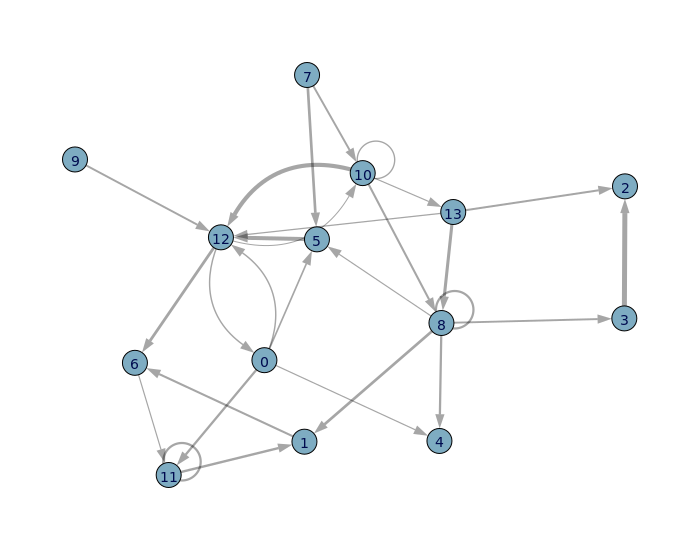

In [64]:
fn = lambda x, sigma, mu: np.exp(-(x - mu)**2/(2*sigma))/np.sqrt(2*np.pi*sigma)
N = 14
g6 = nx.DiGraph()
g6.add_nodes_from(range(N))
for i in range(N):
    weights = fn(np.arange(N), 3, 2) + fn(np.arange(N), 3, 10) + np.random.randn(N,) - 1.2
    weights[weights < 0] = 0.0
    g6.add_weighted_edges_from([(i, j, weights[j]) for j in range(N)]) 
a6 = np.array(nx.adjacency_matrix(g6).todense())

plotting.igdraw(g6)

In [86]:
a7 = a6.copy()
perms = np.random.randint(0, N, (N, 2))
for i, j in perms:
    misc.swapMatrixCols(a7, i, j, inplace=True)
    misc.swapMatrixRows(a7, i, j, inplace=True)
g7 = nx.from_numpy_array(a7)

a8 = a7*np.random.randn(N, N) / 30 + 1
g8 = nx.from_numpy_array(a8)

In [89]:
nx.centrality.approximate_current_flow_betweenness_centrality(g6, weight='weight')

NetworkXNotImplemented: not implemented for directed type